## ニューラルネットワーク  
隠れ層のレイヤーを１個増やしてみた

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import multivariate_normal, permutation
import pandas as pd
from pandas import DataFrame, Series
from sklearn.model_selection import train_test_split

np.random.seed(20160614)
tf.set_random_seed(20160614)

In [2]:
#snssns..set_styleset_sty ('whitegrid')
%matplotlib inline

pd.set_option("display.max_columns", 200) # 表示カラムの最大値
pd.set_option('display.max_rows', 200) # 表示行数の最大値
pd.set_option('display.max_colwidth', 30)
pd.set_option("display.float_format", '{:.3f}'.format) # 小数点以下の有効数字

# jupyterの幅を自動調整
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

### データ読み込み

In [3]:
df = pd.read_csv('../01.data/02.train/data_2013_2017.csv', index_col=0)

In [41]:
# 学習データと検証データに分割
X_train, X_valid, y_train, y_valid = train_test_split(df.iloc[:, 1:df.shape[1]], 
                                                    df['target'], 
                                                    test_size=0.5, 
                                                    random_state=100)
# TensorFlow用に変換
X_train = X_train.as_matrix()
y_train = y_train.as_matrix().reshape([len(y_train), 1])
X_valid = X_valid.as_matrix()
y_valid = y_valid.as_matrix().reshape([len(y_valid), 1])

In [42]:
# 学習データと検証データの正解含有率とレコード件数
print ('train data || Correct Data Rate : %f, Length of data: %i' % (y_train.sum()/len(y_train), len(y_train)))
print ('valid data || Correct Data Rate : %f, Length of data: %i' % (y_valid.sum()/len(y_valid), len(y_valid)))

train data || Correct Data Rate : 0.168576, Length of data: 611
valid data || Correct Data Rate : 0.187908, Length of data: 612


### モデル定義

In [43]:
# Define Variable Functions (weights and bias)
def init_weight(shape, st_dev):
    weight = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return(weight)

def init_bias(shape, st_dev):
    bias = tf.Variable(tf.random_normal(shape, stddev=st_dev))
    return(bias)

# Create a fully connected layer:
def fully_connected(input_layer, weights, biases):
    layer = tf.add(tf.matmul(input_layer, weights), biases)
    return(tf.nn.relu(layer))

### パラメータ

In [73]:
# make results reproducible
seed = 3
np.random.seed(seed)
tf.set_random_seed(seed)

#  説明変数の数
NUM_VARS = X_train.shape[1]

# 学習率
LEARNING_RATE = 0.001

# 投資判断しきい値（accuracyの算出で利用）
INVEST_THRESHOLD = 0.5

# バッチサイズ
batch_size = 300

In [74]:
# 説明変数
x = tf.placeholder(shape=[None, NUM_VARS], dtype=tf.float32)
#目的変数
y = tf.placeholder(shape=[None,1], dtype=tf.float32)

In [75]:
 # 隠れ層１のユニット数
NUM_UNITS_1 = 10
 # 隠れ層２のユニット数
NUM_UNITS_2 = 5

# バイアスの初期値に利用する
mult = X_train.flatten().mean() 

# 隠れ層１を定義
w1 = tf.Variable(tf.truncated_normal([NUM_VARS, NUM_UNITS_1]))
b1 = tf.Variable(tf.zeros([NUM_UNITS_1]))
#hidden1 = tf.nn.tanh(tf.matmul(x, w1) + b1*mult)
hidden1 = tf.nn.relu(tf.matmul(x, w1) + b1*mult)


# 隠れ層2を定義
w2 = tf.Variable(tf.truncated_normal([NUM_UNITS_1, NUM_UNITS_2]))
b2 = tf.Variable(tf.zeros([NUM_UNITS_2]))
#hidden2 = tf.nn.tanh(tf.matmul(hidden1, w2) + b2*mult)
hidden2 = tf.nn.relu(tf.matmul(hidden1, w2) + b2*mult)

# 出力層を定義
w0 = tf.Variable(tf.zeros([NUM_UNITS_2, 1]))
b0 = tf.Variable(tf.zeros([1]))
p = tf.nn.sigmoid(tf.matmul(hidden2, w0) + b0*mult)

**[SNE-05]** 誤差関数 loss、トレーニングアルゴリズム train_step、正解率 accuracy を定義します。

In [76]:
# 誤差関数
loss = -tf.reduce_sum(y*tf.log(p) + (1-y)*tf.log(1-p))
# トレーニングアルゴリズム
train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss)
# 正解率
correct_prediction = tf.equal(tf.sign(p-INVEST_THRESHOLD), tf.sign(y-INVEST_THRESHOLD))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### 学習

In [77]:
sess = tf.Session()

In [94]:
# 変数の初期化
init = tf.global_variables_initializer()
sess.run(init)

saver = tf.train.Saver()

#cwd = os.getcwd() # Windowsのときに必要

i = 0
loss_vec_train = []
loss_vec_valid = []

for _ in range(1000):
    i += 1
    
    batch_index = np.random.choice(len(X_train),  size=batch_size)
    random_X_train = X_train[batch_index]
    random_y_train = y_train[batch_index]
    
    sess.run(train_step, feed_dict={x: random_X_train, y: random_y_train})

    if i % 10 == 0:
        #　トレーニングセットの損失値を保存
        acc_val = sess.run( accuracy, feed_dict={x: X_train, y: y_train})
        loss_vec_train.append(acc_val)        
        # テストセットの損失値を保存
        acc_val = sess.run( accuracy, feed_dict={x: X_valid, y: y_valid})
        loss_vec_valid.append(acc_val)

    if i % 100 == 0:
        loss_val_train, acc_val_train = sess.run( [loss, accuracy], feed_dict={x: X_train, y: y_train})
        loss_val_valid, acc_val_valid = sess.run( [loss, accuracy], feed_dict={x: X_valid, y: y_valid})
        print ('step: %d, train loss: %f,  train accuracy: %f,  , valid loss: %f, valid accuracy: %f' % (i, loss_val_train, 
                                                                                                       acc_val_train, loss_val_valid, acc_val_valid))
    
saver.save(sess, './01.saved_model/model.ckpt')

step: 100, train loss: 276.613983,  train accuracy: 0.831424,  , valid loss: 299.819092, valid accuracy: 0.812092
step: 200, train loss: 277.245239,  train accuracy: 0.831424,  , valid loss: 306.951660, valid accuracy: 0.812092
step: 300, train loss: 271.683929,  train accuracy: 0.831424,  , valid loss: 296.748627, valid accuracy: 0.812092
step: 400, train loss: 267.838257,  train accuracy: 0.831424,  , valid loss: 298.455231, valid accuracy: 0.812092
step: 500, train loss: 265.116974,  train accuracy: 0.831424,  , valid loss: 301.558716, valid accuracy: 0.812092
step: 600, train loss: 269.666809,  train accuracy: 0.831424,  , valid loss: 306.532776, valid accuracy: 0.812092
step: 700, train loss: 263.960205,  train accuracy: 0.831424,  , valid loss: 309.387878, valid accuracy: 0.812092
step: 800, train loss: 258.389008,  train accuracy: 0.831424,  , valid loss: 312.711426, valid accuracy: 0.812092
step: 900, train loss: 263.392761,  train accuracy: 0.831424,  , valid loss: 325.663086,

'./01.saved_model/model.ckpt'

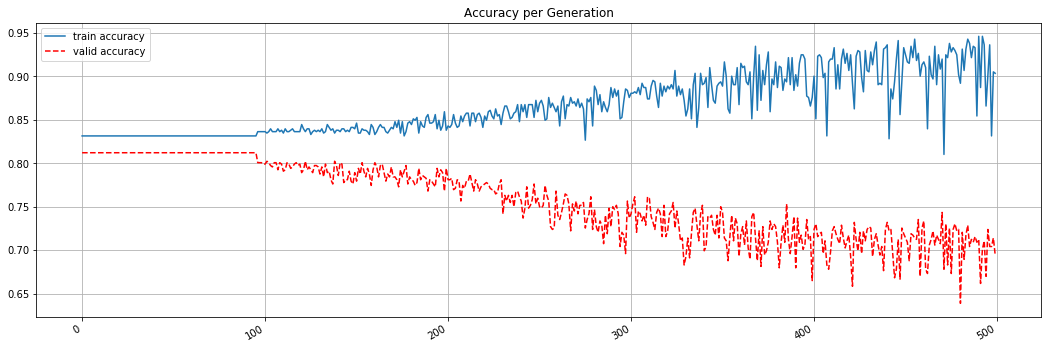

In [79]:
fig = plt.figure(figsize=(18, 6))
ax = plt.subplot()

plt.plot(loss_vec_train,   label='train accuracy')
plt.plot(loss_vec_valid,  'r--',  label='valid accuracy' )
plt.title('Loss (MSE ) per Generation')

ax.grid() #グリッド表示
fig.autofmt_xdate() #x軸のオートフォーマット
plt.legend() # 凡例の表示
plt.title('Accuracy per Generation')
#plt.savefig('ssss.png')
plt.show()